# Disapearing forests - Milestone 2.

## Data preprocessing
The initial preprocessing of the data was using __Shell__. The script used for preprocessing the normalized datasets from __FAOSTAT__ can be found in `data/faostat/clean_me.sh`.

In [12]:
# all the necessary imports
import pandas
from matplotlib import pyplot as plt

In [4]:
# FAOSTAT are are split into multiple groups, FAOSTAT_countries consists from names of the countries
# and FAOSTAT_country_groups consists from bigger areas, such as (Europe, Americas, East Europe etc.)
FAOSTAT_country_data = pd.read_csv("data/faostat/FAOSTAT_countries.csv", engine='python')
FAOSTAT_country_groups = FAOSTAT_country_data["Country Group"].unique()
FAOSTAT_countries = FAOSTAT_country_data["Country"].unique()
CONTINENTS = ['Africa', 'Asia', 'Australia and New Zealand', 'Europe', 'Northern America', 'South America']


## The deforestation trend
At first, we have investifated the trend of deforestation over the time in each country available in our dataset.

### Inputs_LandUse_E_All_Data_cleared.csv

In [5]:
# select tree areas from Inputs_LandUse 
LAND_USE_FOREST_ITEMS = ['Forestry', 'Forest land', 'Primary Forest','Other naturally regenerated forest', 'Planted Forest']

land_use_all = pd.read_csv("data/faostat/Inputs_LandUse_E_All_Data_cleared.csv", engine='python')
land_use = land_use_all[land_use_all.Item.isin(LAND_USE_FOREST_ITEMS) &
                        land_use_all.Element.str.match('Area')]


In [ ]:
# land_use_all.loc[(land_use_all['Area'] == 'Afghanistan') & (land_use_all['Year'] == 1961) |\
#                  (land_use_all['Area'] == 'Afghanistan') & (land_use_all['Year'] == 1988), :]

In [ ]:
# land_use_all.loc[(land_use_all['Area'] == 'Brazil') & (land_use_all['Year'] == 1999) |\
#                  (land_use_all['Area'] == 'Brazil') & (land_use_all['Year'] == 2015), :]

In [917]:
land_use_all['Item'].unique()

array(['Country area', 'Land area', 'Agriculture', 'Agricultural land',
       'Cropland', 'Arable land', 'Land under temporary crops',
       'Land with temporary fallow', 'Land under permanent crops',
       'Land under perm. meadows and pastures',
       'Perm. meadows & pastures - Nat. growing', 'Forestry',
       'Forest land', 'Primary Forest',
       'Other naturally regenerated forest', 'Planted Forest',
       'Other land', 'Land area equipped for irrigation',
       'Agriculture area actually irrigated',
       'Agriculture area under organic agric.',
       'Agriculture area certified organic',
       'Land under temp. meadows and pastures', 'Inland waters',
       'Coastal waters', 'Cropland area actually irrigated',
       'Cropland area under organic agric.',
       'Cropland area certified organic',
       'Perm. meadows & pastures - Cultivated',
       'Land used for aquaculture',
       'Perm. meadows & pastures area actually irrig.',
       'Land under protective cove

In [254]:
# foreseted areas (ha) for every contry per year
forested_area_yearly = land_use[land_use.Area.isin(FAOSTAT_countries)].groupby(["Area", "Year"]).Value.sum()
forested_area_yearly = forested_area_yearly.unstack("Year")


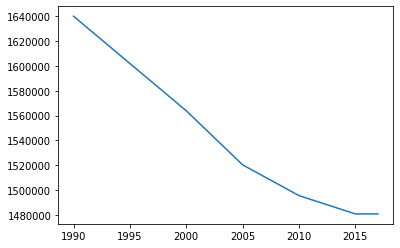

In [255]:
# plot forested area in Brazil over years
plt.plot(forested_area_yearly.loc['Brazil'])
plt.show()

> **Plot is the sum of non disjoint sets of values**

In [263]:
# NEW

# total foreseted area (ha) for every contry per year
total_forested_area_yearly = land_use[land_use.Area.isin(FAOSTAT_countries) & 
                                    land_use.Item.str.match('Forestry')]

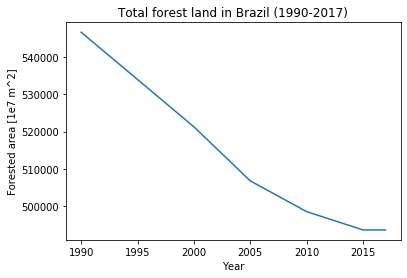

In [264]:
# NEW

# plot forested area in Brazil over years
brazil_forested_area_yearly = total_forested_area_yearly.loc[total_forested_area_yearly['Area'] == 'Brazil']
plt.plot(brazil_forested_area_yearly['Year'], brazil_forested_area_yearly['Value'])
plt.title('Total forest land in Brazil (1990-2017)')
# plt.gca().set_ylim([0, 580000])
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forested area [1e7 m^2]')
plt.show()

In [73]:
# land_use_all.loc[(land_use_all['Area'] == 'Brazil') & 
#                  (land_use_all['Year'] == 2015) &
#                  (land_use_all['Element'] == 'Area') &
#                  (land_use_all['Item'].isin(LAND_USE_FOREST_ITEMS)), :]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
19605,21,Brazil,6663,Forestry,5110,Area,2015,2015,1000 ha,493538.0,Q
19633,21,Brazil,6646,Forest land,5110,Area,2015,2015,1000 ha,493538.0,Q
19689,21,Brazil,6714,Primary Forest,5110,Area,2015,2015,1000 ha,202691.0,Q
19717,21,Brazil,6717,Other naturally regenerated forest,5110,Area,2015,2015,1000 ha,283111.0,Q
19745,21,Brazil,6716,Planted Forest,5110,Area,2015,2015,1000 ha,7736.0,Q


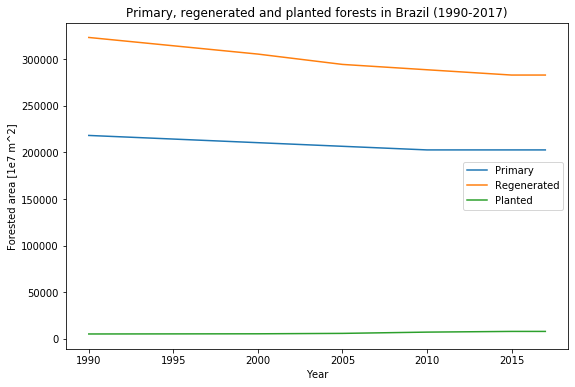

<Figure size 432x288 with 0 Axes>

In [918]:
# NEW

# Remove the aggregated values 'Forestry' and 'Forest Land',
# keep 'Primary Forest', 'Other naturally regenerated forest' and 'Planted Forest'
LAND_USE_PARTIAL_FOREST_ITEMS = LAND_USE_FOREST_ITEMS[2::]

NATION = 'Brazil'

partial_forested_area_yearly = land_use.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS))]
national_forested_area_yearly = partial_forested_area_yearly.loc[partial_forested_area_yearly['Area'] == NATION]

plt.figure(figsize=(9, 6))
plt.plot(national_forested_area_yearly.loc[partial_forested_area_yearly['Item'] == 'Primary Forest']['Year'],
         national_forested_area_yearly.loc[partial_forested_area_yearly['Item'] == 'Primary Forest']['Value'])
plt.plot(national_forested_area_yearly.loc[partial_forested_area_yearly['Item'] == 'Other naturally regenerated forest']['Year'], 
         national_forested_area_yearly.loc[partial_forested_area_yearly['Item'] == 'Other naturally regenerated forest']['Value'])
plt.plot(national_forested_area_yearly.loc[partial_forested_area_yearly['Item'] == 'Planted Forest']['Year'], 
         national_forested_area_yearly.loc[partial_forested_area_yearly['Item'] == 'Planted Forest']['Value'])
plt.title('Primary, regenerated and planted forests in ' + NATION + ' (1990-2017)')
plt.legend(['Primary', 'Regenerated', 'Planted'])
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forested area [1e7 m^2]')
plt.show()
plt.savefig(NATION + '_primary_regenerated_planted_forests')

In [265]:
# forested areas in continents over yers
continents_forests_area = land_use_all[land_use_all.Item.isin(LAND_USE_FOREST_ITEMS) &   
                                       land_use_all.Element.str.match('Area') & 
                                       land_use.Area.isin(CONTINENTS)].groupby(["Area", "Year"]).Value.sum()

continents_forests_area = continents_forests_area.unstack("Year")


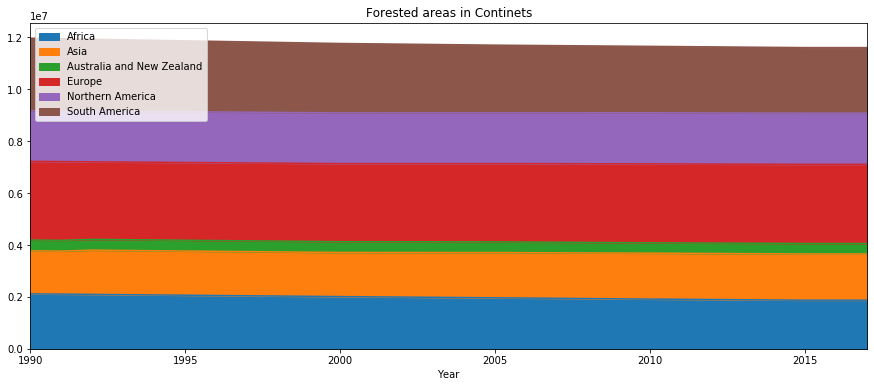

In [266]:
# plot forested areas in continents over years
continetns_forests_plot = continents_forests_area.T.plot.area(figsize=(15,6), title="Forested areas in Continets")
continetns_forests_plot.legend(loc='upper left')


> + **Not stacked?**
> + **Still sum of non disjoint values**

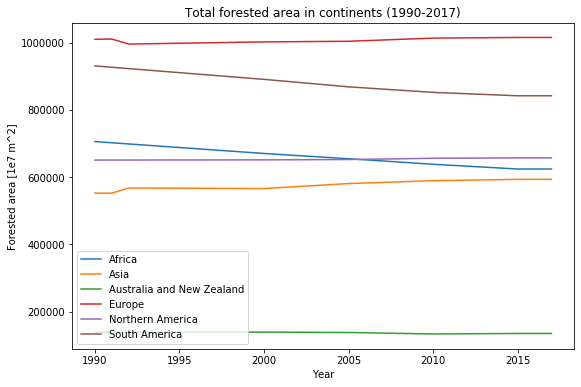

In [267]:
# NEW

# forested areas in continents over yers
continents_forests_area = land_use_all[land_use_all.Item.str.match('Forestry') &   
                                       land_use_all.Element.str.match('Area') & 
                                       land_use.Area.isin(CONTINENTS)]

plt.figure(figsize=(9, 6))
for continent in sorted(continents_forests_area.Area.unique().tolist()):
    plt.plot(continents_forests_area[continents_forests_area['Area'] == continent]['Year'],
             continents_forests_area[continents_forests_area['Area'] == continent]['Value'])
plt.title('Total forested area in continents (1990-2017)')
plt.legend(sorted(continents_forests_area.Area.unique().tolist()), loc='best')
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forested area [1e7 m^2]')
plt.show()

In [256]:
# fill missing values in the forested_area_yearly (contry per year areas) by the most left valid value
forested_area_yearly = forested_area_yearly.fillna(method="backfill")


In [257]:
# The 20 countries which have deforestated most of forested areas over the years
forested_areas_diff = forested_area_yearly.iloc[:, 0] - forested_area_yearly.iloc[:, -1]
forested_areas_diff = forested_areas_diff.sort_values(ascending=False)
forested_areas_diff[:20]

Area
USSR                                2542048.800
Brazil                               159501.000
Indonesia                             82605.000
Kyrgyzstan                            50983.700
Ethiopia PDR                          50205.000
Sudan (former)                        46185.939
Luxembourg                            40815.900
Tajikistan                            40779.000
Micronesia (Federated States of)      37415.205
Northern Mariana Islands              36307.512
Bosnia and Herzegovina                34599.000
Sudan                                 34552.125
Lithuania                             34536.000
North Macedonia                       33402.000
Nigeria                               30723.000
Myanmar                               30531.000
United Republic of Tanzania           29580.000
Georgia                               25432.800
Zimbabwe                              24306.000
Bolivia (Plurinational State of)      24093.000
dtype: float64

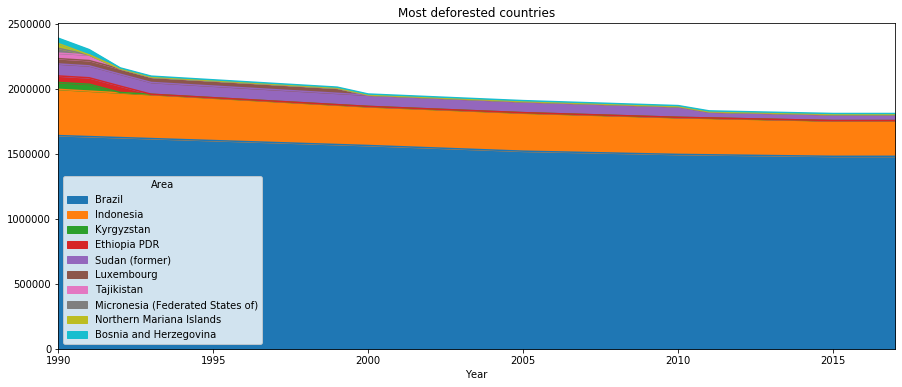

In [258]:
#The 10 countries which have deforestated most of forested areas over the years (without USSR)
# USSR stoped existing so the value has droped rapidly after dissolution od Soviet Union
forested_area_yearly.loc[forested_areas_diff[1:11].index].T.plot.area(figsize=(15,6), title="Most deforested countries")


In [259]:
# The 20 countries with biggest expansion of forests
forested_areas_diff[-20:]
# Russian Federation seems as an Outlier

Area
Iran (Islamic Republic of)      -4847.766
Italy                           -5121.000
Estonia                         -5280.000
Turkey                          -6279.000
Thailand                        -7182.000
Chile                           -7416.000
France                          -7659.000
Serbia                          -8038.002
Uzbekistan                      -8339.700
Latvia                          -9675.000
Turkmenistan                   -12277.800
Spain                          -13825.140
Viet Nam                       -16230.000
India                          -20229.000
United States of America       -22935.000
Belarus                        -23610.900
Ukraine                        -28236.000
Yugoslav SFR                  -118608.000
China:mainland                -153542.100
Russian Federation           -2443837.500
dtype: float64

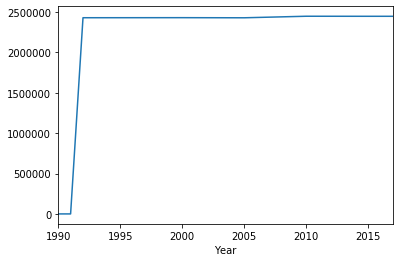

In [260]:
# we can truly observe that there is an inconsistency in the data
forested_area_yearly.loc["Russian Federation"].plot()


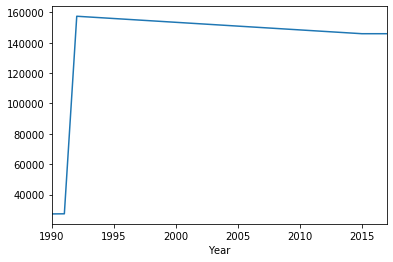

In [262]:
# NEW

# inconsistency also for Yugoslav
forested_area_yearly.loc["Yugoslav SFR"].plot()

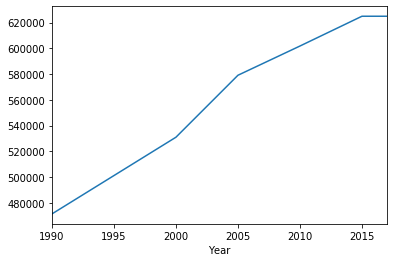

In [261]:
# China, mainland seem to have an increasing areas of forest over the time
forested_area_yearly.loc["China:mainland"].plot()

### Environment_LandUse_E_All_Data_cleared.csv

In [415]:
# load ENV LansUse and select share of the forests in the each Area per yesr 
ENV_LAND_USE_FOREST = ['Forest land', 'Primary Forest', 'Planted Forest', 
                       'Other naturally regenerated forest']

env_land_use_all = pd.read_csv("data/faostat/Environment_LandUse_E_All_Data_cleared.csv", engine='python')

env_land_use = env_land_use_all[env_land_use_all.Item.isin(ENV_LAND_USE_FOREST) & env_land_use_all.Element.str.match("Share in Land area")]

env_land_use_yearly = env_land_use.groupby(["Area", "Year"]).Value.sum()
env_land_use_yearly = env_land_use_yearly.unstack("Year").fillna(method="backfill", axis=0)


In [920]:
env_land_use

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
464,2,Afghanistan,6646,Forest land,7209,Share in Land area,1990,1990,%,2.07,Fc
465,2,Afghanistan,6646,Forest land,7209,Share in Land area,1991,1991,%,2.07,Fc
466,2,Afghanistan,6646,Forest land,7209,Share in Land area,1992,1992,%,2.07,Fc
467,2,Afghanistan,6646,Forest land,7209,Share in Land area,1993,1993,%,2.07,Fc
468,2,Afghanistan,6646,Forest land,7209,Share in Land area,1994,1994,%,2.07,Fc
...,...,...,...,...,...,...,...,...,...,...,...
132637,5873,OECD,6646,Forest land,7209,Share in Land area,2012,2012,%,31.25,Fc
132638,5873,OECD,6646,Forest land,7209,Share in Land area,2013,2013,%,31.28,Fc
132639,5873,OECD,6646,Forest land,7209,Share in Land area,2014,2014,%,31.31,Fc
132640,5873,OECD,6646,Forest land,7209,Share in Land area,2015,2015,%,31.35,Fc


In [919]:
env_land_use_yearly

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,...,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07
Africa,23.80,23.68,23.57,23.45,23.33,23.21,23.09,22.97,22.85,22.73,...,21.86,21.75,21.64,21.53,21.43,21.34,21.24,21.15,21.05,20.95
Albania,28.79,28.72,28.65,28.57,28.50,28.43,28.36,28.29,28.22,28.15,...,28.47,28.42,28.38,28.33,28.30,28.26,28.23,28.19,28.16,28.12
Algeria,0.70,0.70,0.69,0.69,0.69,0.68,0.68,0.67,0.67,0.67,...,0.71,0.74,0.77,0.81,0.81,0.81,0.81,0.82,0.82,0.82
American Samoa,91.95,91.75,91.60,91.45,91.25,91.10,90.95,90.75,90.60,90.40,...,89.05,88.90,88.75,88.55,88.40,88.20,88.05,87.90,87.70,87.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
World,31.62,31.57,31.62,31.57,31.51,31.46,31.40,31.33,31.28,31.22,...,30.95,30.92,30.90,30.87,30.84,30.82,30.79,30.77,30.74,30.72
Yemen,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04
Yugoslav SFR,35.73,35.82,70.58,70.35,70.13,69.91,69.68,69.46,69.23,69.01,...,67.22,66.99,66.77,66.54,66.32,66.10,65.87,65.65,65.42,65.20


In [289]:
# NEW

# Wrong rows (percentgage > 100%)
env_land_use_all.Value[env_land_use_all.Value > 100].count()

18

> + **Some values are outside the range [0, 100]**

In [365]:
# NEW

# check unique values of columns
print(env_land_use_all.Element.unique(), end='\n\n')
print(env_land_use_all.Item.unique())

['Share in Agricultural land' 'Share in Land area' 'Share in Forest land']

['Arable land' 'Land under permanent crops' 'Cropland'
 'Land under perm. meadows and pastures'
 'Agriculture area actually irrigated' 'Land area equipped for irrigation'
 'Agricultural land' 'Forest land' 'Primary Forest' 'Planted Forest'
 'Other naturally regenerated forest'
 'Agriculture area under organic agric.']


In [366]:
# NEW

# Show all the data for specific country and year
env_land_use_all.loc[env_land_use_all.Area.str.match('Brazil') & (env_land_use_all.Year == 2015)]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
13119,21,Brazil,6621,Arable land,7208,Share in Agricultural land,2015,2015,%,28.69,Fc
13175,21,Brazil,6650,Land under permanent crops,7208,Share in Agricultural land,2015,2015,%,2.31,Fc
13231,21,Brazil,6620,Cropland,7208,Share in Agricultural land,2015,2015,%,31.01,Fc
13287,21,Brazil,6620,Cropland,7209,Share in Land area,2015,2015,%,10.54,Fc
13343,21,Brazil,6655,Land under perm. meadows and pastures,7208,Share in Agricultural land,2015,2015,%,68.99,Fc
13399,21,Brazil,6655,Land under perm. meadows and pastures,7209,Share in Land area,2015,2015,%,23.45,Fc
13456,21,Brazil,6690,Land area equipped for irrigation,7208,Share in Agricultural land,2015,2015,%,1.90,Fc
13512,21,Brazil,6610,Agricultural land,7209,Share in Land area,2015,2015,%,33.99,Fc
13539,21,Brazil,6646,Forest land,7209,Share in Land area,2015,2015,%,59.05,Fc
13566,21,Brazil,6714,Primary Forest,7210,Share in Forest land,2015,2015,%,41.07,Fc


In [367]:
# NEW

# Percenteges total is actually 100?
COUNTRY = 'Brazil'
YEAR = 2015
env_land_use_all.loc[env_land_use_all.Area.str.match(COUNTRY) & (env_land_use_all.Year == YEAR)]\
                .groupby('Element')\
                .sum()\
                .loc[:, 'Value']

Element
Share in Agricultural land    133.16
Share in Forest land          100.00
Share in Land area            127.03
Name: Value, dtype: float64

> + **Share in Forest land seems to always sum to 100**
> + **Why the other two don't sum to 100?**

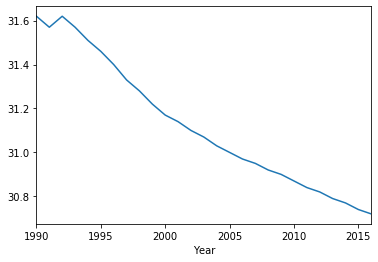

In [453]:
env_land_use_yearly.loc['World'].plot()


> + **(On y axis: percentage of ferested land)**
> + **Same plot could be done with the previous dataset, it's only 'Forest land' per year whole world**

In [460]:
env_land_use_diff = env_land_use_yearly[env_land_use_yearly.index.isin(FAOSTAT_countries)].iloc[:, 0] -\
                    env_land_use_yearly[env_land_use_yearly.index.isin(FAOSTAT_countries)].iloc[:, -1]

env_land_use_diff = env_land_use_diff.sort_values(ascending=False)


In [461]:
# the top 20 countries which have deforestated by % of deforestated areas
env_land_use_diff[:20]


Area
Pacific Islands Trust Territory          80.36
Serbia                                   57.29
Azerbaijan                               37.35
Honduras                                 32.74
USSR                                     29.07
Uzbekistan                               28.56
Turkmenistan                             27.43
Democratic People's Republic of Korea    27.38
Slovakia                                 27.14
Tajikistan                               24.44
Zimbabwe                                 21.75
Kyrgyzstan                               21.26
Cambodia                                 20.48
Timor-Leste                              19.58
United States Virgin Islands             17.40
Myanmar                                  16.38
Indonesia                                15.58
Paraguay                                 15.50
Republic of Moldova                      15.20
Uganda                                   14.10
dtype: float64

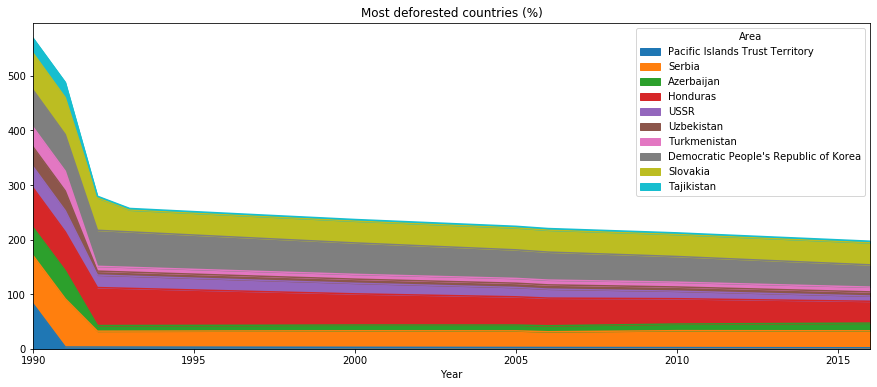

In [462]:
env_land_use_yearly.loc[env_land_use_diff[:10].index].T.plot.area(figsize=(15,6), title="Most deforested countries (%)")


> + **Start from 1992 since in 1991 there's a drop in PITT, Serbia, URSS...**
> + **No sense to stack percentages (y axis meaning?)**

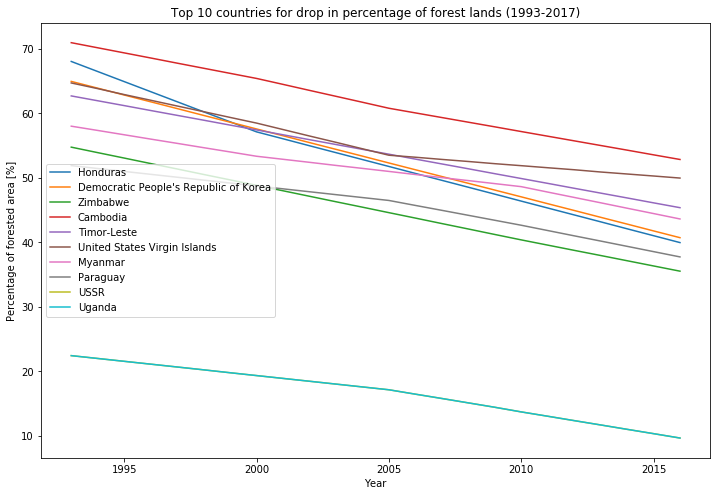

In [463]:
# NEW

# start from 1993 to avoid big drops in Serbia, Slovakia, Eritrea...
# env_land_use_yearly can be replaced by Inputs_LandUse_E_All_Data_cleared dataset,
# which already contains data for forested land (even if not percentage, but can be easily computed)

# column 3 -> 1993, column -1 -> 2017
env_land_use_diff_from_1993 = env_land_use_yearly[env_land_use_yearly.index.isin(FAOSTAT_countries)].iloc[:, 3] -\
                              env_land_use_yearly[env_land_use_yearly.index.isin(FAOSTAT_countries)].iloc[:, -1]
env_land_use_diff_from_1993 = env_land_use_diff_from_1993.sort_values(ascending=False)

forested_percentage_yearly = env_land_use_yearly.drop([1990, 1991, 1992], axis=1)

plt.figure(figsize=(12,8))
for country in env_land_use_diff_from_1993.index[0:10]:
    plt.plot(forested_percentage_yearly.columns.values, 
             forested_percentage_yearly.loc[forested_percentage_yearly.index == country].values[0])

plt.legend(env_land_use_diff_from_1993.index[0:10])
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Percentage of forested area [%]')
plt.title('Top 10 countries for drop in percentage of forest lands (1993-2017)')
plt.show()

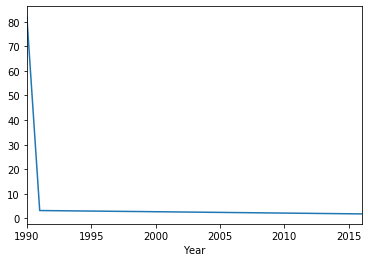

In [464]:
# develoment of forests in Pacific Islands Trust Territory (%)
env_land_use_yearly.loc["Pacific Islands Trust Territory"].plot()

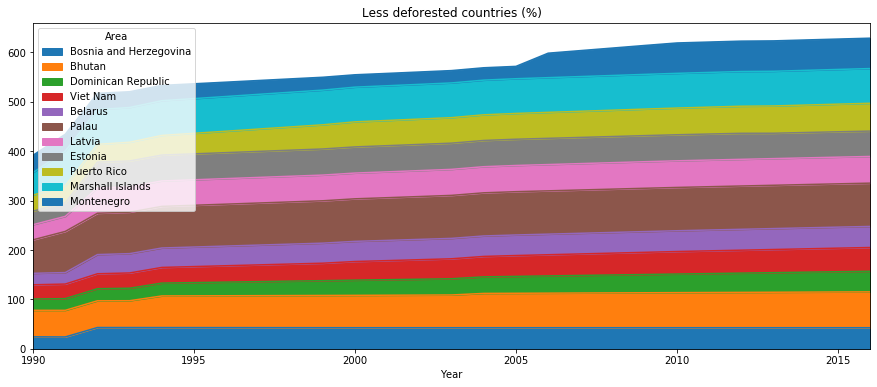

In [478]:
env_land_use_yearly.loc[env_land_use_diff[-20:-9].index].T.plot.area(figsize=(15,6), title="Less deforested countries (%)")


> + **Again: no sense to stack percentages (y axis meaning?)**
> + **Why [-20:-9] if I want the top 10? [-10:-1]?**

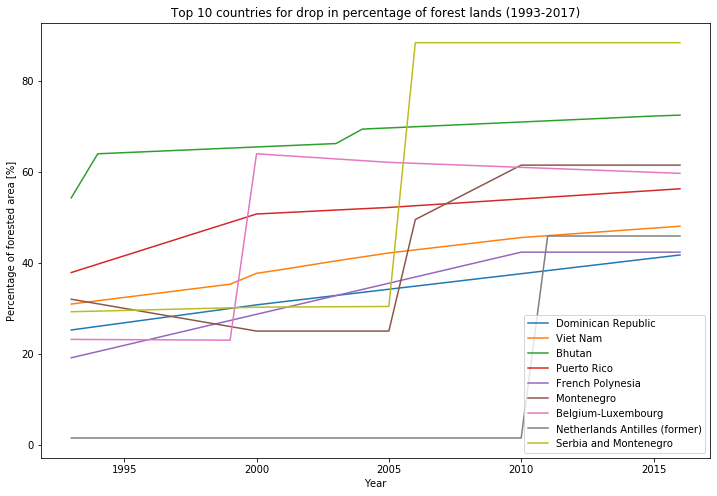

In [477]:
# NEW

# top 10 countries for increasing percentage of forested areas
plt.figure(figsize=(12,8))
for country in env_land_use_diff_from_1993.index[-10:-1]:
    plt.plot(forested_percentage_yearly.columns.values, 
             forested_percentage_yearly.loc[forested_percentage_yearly.index == country].values[0])

plt.legend(env_land_use_diff_from_1993.index[-10:-1])
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Percentage of forested area [%]')
plt.title('Top 10 countries for drop in percentage of forest lands (1993-2017)')
plt.show()

> + **Very messy, data cleaning needed**

### Environment_LandCover_E_All_Data_cleared.csv

In [487]:
# load ENV landConver and select tree covered ares (per country per year) and split them by origin
env_land_cover_all = pd.read_csv("data/faostat/Environment_LandCover_E_All_Data_cleared.csv", engine='python')

env_land_cover_MODIS = env_land_cover_all[env_land_cover_all.Item.str.match("Tree-covered areas") &
                                          env_land_cover_all.Element.str.match("Area from MODIS")]\
                                         .groupby(["Area", "Year"])\
                                         .Value.sum()\
                                         .unstack("Year")\
                                         .fillna(method="backfill")

env_land_cover_CCI_LC = env_land_cover_all[env_land_cover_all.Item.str.match("Tree-covered areas") &
                                           env_land_cover_all.Element.str.match("Area from CCI_LC")]\
                                          .groupby(["Area", "Year"])\
                                          .Value.sum()\
                                          .unstack("Year")\
                                          .fillna(method="backfill")


In [496]:
env_land_cover_all.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,6970,Artificial surfaces (including urban and assoc...,5007,Area from MODIS,2001,2001,1000 ha,88.7828,FC
1,2,Afghanistan,6970,Artificial surfaces (including urban and assoc...,5007,Area from MODIS,2002,2002,1000 ha,88.8043,FC
2,2,Afghanistan,6970,Artificial surfaces (including urban and assoc...,5007,Area from MODIS,2003,2003,1000 ha,88.8472,FC
3,2,Afghanistan,6970,Artificial surfaces (including urban and assoc...,5007,Area from MODIS,2004,2004,1000 ha,88.8472,FC
4,2,Afghanistan,6970,Artificial surfaces (including urban and assoc...,5007,Area from MODIS,2005,2005,1000 ha,88.9116,FC


In [518]:
env_land_cover_all.Unit.unique()

array(['1000 ha'], dtype=object)

In [544]:
env_land_cover_all.Item.unique()

array(['Artificial surfaces (including urban and associated areas)',
       'Herbaceous crops', 'Woody crops', 'Multiple or layered crops',
       'Grassland', 'Tree-covered areas', 'Mangroves',
       'Shrub-covered areas',
       'Shrubs and/or herbaceous vegetation:aquatic or regularly flooded',
       'Sparsely natural vegetated areas', 'Terrestrial barren land',
       'Permanent snow and glaciers', 'Inland water bodies',
       'Coastal water bodies and intertidal areas'], dtype=object)

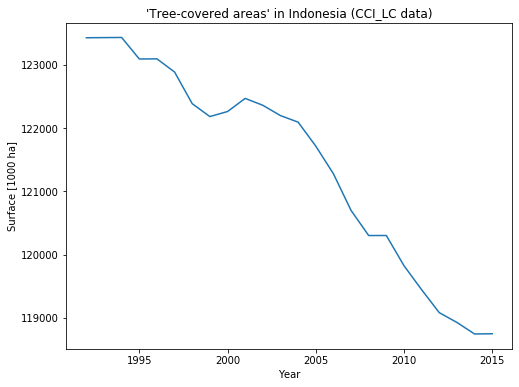

In [620]:
# NEW

# 1) select COUNTRY and DATA_TYPE
# 2) choose if you want to plot all the valailable statistics (PLOT_UNIQUE = False)
#    or just one; in his case (PLOT_UNIQUE = True), select the statistic in UNIQUE_LAND_TYPE

COUNTRY = 'Indonesia'
DATA_TYPE = 'CCI_LC' # 'CCI_LC' or 'MODIS'
PLOT_UNIQUE = True
UNIQUE_LAND_TYPE = 'Tree-covered areas'

land_types = env_land_cover_all.Item.unique()
for LAND_TYPE in land_types:
    selected_item_yearly = env_land_cover_all.loc[(env_land_cover_all['Item'] == LAND_TYPE) &
                                                  (env_land_cover_all.Area.str.match(COUNTRY)) &
                                                  (env_land_cover_all.Element.str.match('Area from ' + DATA_TYPE)), 
                                                  ['Value', 'Year']]
    if PLOT_UNIQUE & (UNIQUE_LAND_TYPE != LAND_TYPE):
        continue
    if selected_item_yearly.Value.isnull().sum() == 0: # if the selected LAND_TYPE is registered every year
        plt.figure(figsize=(8, 6))
        plt.plot(selected_item_yearly['Year'], selected_item_yearly['Value'])
        plt.title("'" + LAND_TYPE + "' in " + COUNTRY + " (" + DATA_TYPE + " data)")
        plt.gca().set_xlabel('Year')
        plt.gca().set_ylabel('Surface [1000 ha]')
        plt.show()

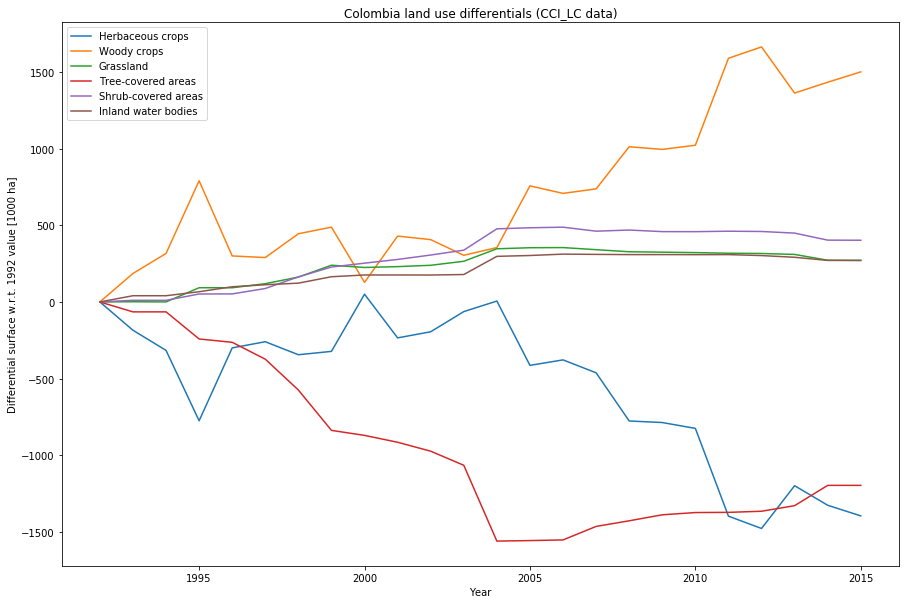

<Figure size 432x288 with 0 Axes>

In [916]:
# NEW

# 1) select COUNTRY and DATA_TYPE
# 2) choose a threshold for filtering the significant columns for the plot. 
#    The threshold depends on COUNTRY and DATA_TYPE.
#    Suggested thresholds: Switzerland,   MODIS   -> 300
#                          Switzerland,   CCI_LC  -> 300
#                          Brazil,        MODIS   -> 10000
#                          Brazil,        CCI_LC  -> 30000

COUNTRY = 'Colombia'
DATA_TYPE = 'CCI_LC' # 'CCI_LC' or 'MODIS'
THRESHOLD_SIGNIFICANT_LAND_TYPE = 1000


def is_significant(column, threshold):
    """
    Check if the current column contains high variations (w.r.t. the threshold) during the years.
    Total variation is computed as sum of yearly variation w.r.t. reference year.
    """
    cumulative_sum = column.values.sum()
    if abs(cumulative_sum) < threshold:
        return False
    else:
        return True
    

# create a DataFrame with year as only column. Years listed depend on the DATA_TYPE
country_land_types_yearly = pd.DataFrame(env_land_cover_all[env_land_cover_all.Element.str.match('Area from ' + DATA_TYPE)].Year.unique(), 
                                         columns=['Year'])

# fill the DataFrame columns: each column is a specific land type, each row is a year
land_types = env_land_cover_all.Item.unique()
for LAND_TYPE in land_types:
    selected_item_yearly = env_land_cover_all.loc[(env_land_cover_all['Item'] == LAND_TYPE) &
                                                  (env_land_cover_all.Area.str.match(COUNTRY)) &
                                                  (env_land_cover_all.Element.str.match('Area from ' + DATA_TYPE)), 
                                                  'Value']
    if selected_item_yearly.isnull().sum() == 0: # if the selected LAND_TYPE is registered every year
        country_land_types_yearly[LAND_TYPE] = selected_item_yearly.values

# compute differences w.r.t. first year of measurement for every column
starting_year = country_land_types_yearly.iloc[0, 0]
country_land_types_year_diff = country_land_types_yearly - country_land_types_yearly.iloc[0, :]
country_land_types_year_diff['Year'] = country_land_types_year_diff['Year'] + starting_year    # restore correct year after subtraction

# set 'Year' as the new index
country_land_types_year_diff.set_index('Year', inplace=True)

plt.figure(figsize=(15, 10))
selected_land_types = []

for column_index, LAND_TYPE in enumerate(country_land_types_year_diff.columns):
    
    # skip column (time series for selected LAND_TYPE) if not significant change is visible
    if is_significant(country_land_types_year_diff.loc[:, LAND_TYPE], THRESHOLD_SIGNIFICANT_LAND_TYPE):
        
        # save current column index to print column name in legend
        selected_land_types.append(column_index)
        
        plt.plot(country_land_types_year_diff.index,
                 country_land_types_year_diff[LAND_TYPE])

plt.title(COUNTRY + " land use differentials (" + DATA_TYPE + " data)")
plt.legend(country_land_types_year_diff.columns[selected_land_types])
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Differential surface w.r.t. ' + str(int(country_land_types_year_diff.index[0])) + ' value [1000 ha]')
plt.show()
plt.savefig(COUNTRY + "_differentials_" + DATA_TYPE)

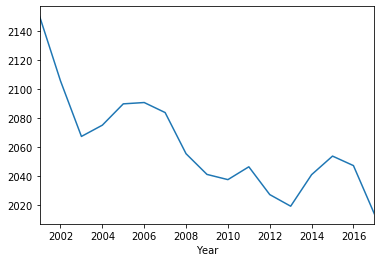

In [483]:
# plot forest are in Switzerland per year base on the MODIS data
env_land_cover_MODIS.loc["Switzerland"].plot()


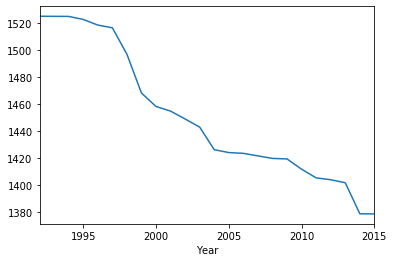

In [484]:
# plot forest are in Switzerland per year base on the CCI_LC data
env_land_cover_CCI_LC.loc["Switzerland"].plot()


#### Note to the CCI_LC & MODIS
**MODIS** data are only from the year 2001, they seem to differ from the **CCI_LC** data.


> + **Very difficult data to be understood**
> + **No need to sum (see first cell of section): 'Area' == 'Switzerland' and 'Item' == 'Tree-covered areas' univoquely identify the item**

## The wood trade
Later we've started to look for the biggest producers and consumers of the wood in the world.

In [603]:
# load Forestry data
forest_all = pd.read_csv("data/faostat/Forestry_E_All_Data_cleared.csv", engine='python')
forest_trade = pd.read_csv("data/faostat/Forestry_Trade_Flows_E_All_Data_cleared.csv", engine='python')


In [921]:
forest_all.Item.unique()

array(['Forest products (export/import)', 'Roundwood',
       'Roundwood:coniferous (production)',
       'Roundwood:non-coniferous (production)', 'Wood fuel',
       'Wood fuel:coniferous', 'Wood fuel:non-coniferous',
       'Wood fuel:all species (export/import)', 'Industrial roundwood',
       'Industrial roundwood:coniferous',
       'Industrial roundwood:coniferous (export/import)',
       'Industrial roundwood:non-coniferous',
       'Industrial roundwood:non-coniferous tropical (export/import)',
       'Industrial roundwood:non-coniferous non-tropical (export/import)',
       'Sawlogs and veneer logs', 'Sawlogs and veneer logs:coniferous',
       'Sawlogs and veneer logs:non-coniferous',
       'Other industrial roundwood',
       'Other industrial roundwood:coniferous (production)',
       'Other industrial roundwood:non-coniferous (production)',
       'Wood charcoal', 'Wood chips:particles and residues',
       'Wood chips and particles', 'Wood residues', 'Sawnwood',
       '

In [925]:
temp = forest_all.loc[forest_all.Element.str.match("Production") &
                      forest_all.Area.str.match("Brazil") &
                      (forest_all.Year == 2015) &
                      forest_all.Item.isin(['Roundwood', 'Roundwood:coniferous (production)', 'Roundwood:non-coniferous (production)',
                                            'Industrial roundwood', 'Wood fuel'])]
temp

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
174563,21,Brazil,1861,Roundwood,5516,Production,2015,2015,m3,247884000.0,A
174849,21,Brazil,1862,Roundwood:coniferous (production),5516,Production,2015,2015,m3,42464950.0,A
174907,21,Brazil,1863,Roundwood:non-coniferous (production),5516,Production,2015,2015,m3,205419050.0,A
174965,21,Brazil,1864,Wood fuel,5516,Production,2015,2015,m3,111707000.0,A
175367,21,Brazil,1865,Industrial roundwood,5516,Production,2015,2015,m3,136177000.0,A


In [769]:
forest_all.Unit.unique()

array(['1000 US$', 'm3', 'tonnes'], dtype=object)

In [770]:
forest_all.Element.unique()

array(['Import Value', 'Export Value', 'Production', 'Import Quantity',
       'Export Quantity'], dtype=object)

In [604]:
# the wood production of countries in m3
wood_production_m3 = forest_all[forest_all.Element.str.match("Production") & 
                                forest_all.Area.isin(FAOSTAT_countries) & 
                                forest_all.Unit.str.match("m3")]\
                                .groupby(["Area", "Year"])\
                                .Value.sum().unstack("Year")


> + **Is it right to sum on all the 'Item's? Check on website**

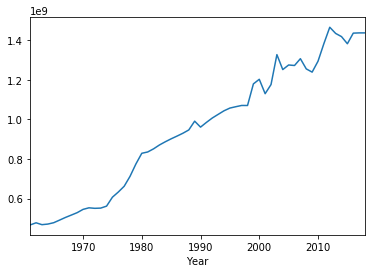

In [605]:
# the wood production of Brazil in m3
wood_production_m3.loc["Brazil"].plot()

In [606]:
# the biggest producer of wood in 2018
wood_production_m3.loc[:, 2018].sort_values(ascending=False).head(20)


Area
United States of America            2.862400e+09
China:mainland                      2.546835e+09
Russian Federation                  1.589406e+09
India                               1.534867e+09
Brazil                              1.436541e+09
Canada                              1.137304e+09
Indonesia                           6.445435e+08
Sweden                              5.032570e+08
Germany                             5.022776e+08
Ethiopia                            4.603311e+08
Finland                             4.588330e+08
Chile                               3.923023e+08
Democratic Republic of the Congo    3.662536e+08
Poland                              3.358665e+08
Nigeria                             3.278924e+08
France                              3.142304e+08
Australia                           2.710942e+08
Viet Nam                            2.454429e+08
Japan                               2.147920e+08
Mexico                              2.122413e+08
Name: 2018, dty

In [607]:
wood_production_tonnes = forest_all[forest_all.Element.str.match("Production") & 
                                forest_all.Area.isin(FAOSTAT_countries) & 
                                forest_all.Unit.str.match("tonnes")]\
                                .groupby(["Area", "Year"])\
                                .Value.sum().unstack("Year")


In [608]:
wood_production_tonnes.loc[:, 2018].sort_values(ascending=False).head(20)

Area
China:mainland              819880071.0
United States of America    790735011.0
Japan                       226970000.0
Brazil                      205199800.0
Germany                     168215554.0
Canada                      143986343.0
Sweden                      125128144.0
Indonesia                   121407968.0
Finland                     117565447.0
India                       117236100.0
Russian Federation          109286772.0
Republic of Korea            82557000.0
France                       72289261.0
Italy                        65448173.0
Spain                        57385168.0
Thailand                     46048810.0
Mexico                       45740000.0
Austria                      45225485.0
Poland                       43051108.0
Chile                        38294775.0
Name: 2018, dtype: float64

In [609]:
# wood export of countries per year in m3
wood_export_m3 = forest_all[forest_all.Element.str.match("Export Quantity") & 
                            forest_all.Unit.str.match("m3") & 
                            forest_all.Area.isin(FAOSTAT_countries)]\
                           .groupby(["Area", "Year"])\
                           .Value.sum()\
                           .unstack("Year")


In [610]:
wood_export_tonnes = forest_all[forest_all.Element.str.match("Export Quantity") & 
                                forest_all.Unit.str.match("tonnes") & 
                                forest_all.Area.isin(FAOSTAT_countries)]\
                                .groupby(["Area", "Year"])\
                                .Value.sum()\
                                .unstack("Year")


In [611]:
wood_export_m3.loc[:, 2018].sort_values(ascending=False).head(10)


Area
Russian Federation          159085467.0
Canada                      108484104.0
New Zealand                 100992260.0
United States of America     83218571.0
Germany                      60288070.0
Australia                    46625726.0
Czechia                      35948676.0
Poland                       33188613.0
Viet Nam                     31409440.0
France                       29555247.0
Name: 2018, dtype: float64

In [612]:
wood_export_tonnes.loc[:, 2018].sort_values(ascending=False).head(10)


Area
United States of America    160562185.0
Canada                       98102389.0
Brazil                       92900134.0
Germany                      90893070.0
Finland                      77437050.0
Sweden                       71448776.0
Indonesia                    49749723.0
China:mainland               33079734.0
Russian Federation           32694767.0
Chile                        29571144.0
Name: 2018, dtype: float64

In [614]:
forest_trade.Element.unique()


array(['Import Value', 'Import Quantity', 'Export Value',
       'Export Quantity'], dtype=object)

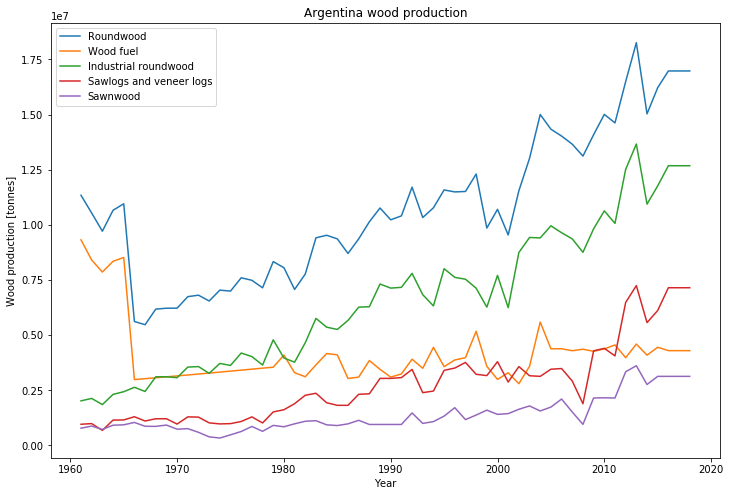

In [928]:
# NEW

# Types of wood production.
# Plot only categories that:
# 1) existed since 1962
# 2) have a production value (in 2018) that is above the avarage of the values among all categories
# 3) are aggregated and do not distinguish between coniferous and non-coniferous
COUNTRY = 'Argentina'
UNIT = 'tonnes'  # 'm3' or 'tonnes'

country_total_production = forest_all[forest_all.Element.str.match("Production") & 
                                      forest_all.Area.str.match(COUNTRY) & 
                                      forest_all.Unit.str.match("m3")]

# 1) for COUNTRY, find categories ('Item') that didn't change name between 1962 and 2018 (hopefully they are the most important)
longlasting_items = []
for wood_category in country_total_production.loc[(country_total_production.Year == 1962), 'Item'].unique():
    if wood_category in country_total_production.loc[(country_total_production.Year == 2018), 'Item'].unique():
        longlasting_items.append(wood_category)

# 2) among the longlasting_items, select those which have a 'Value' above the mean in 2018 (the most important ones)
country_significant_items = country_total_production.loc[(country_total_production.Year == 2018) & 
                                                         (country_total_production.Item.isin(longlasting_categories))]\
                                                    .loc[(country_total_production.Value > country_total_production.Value.mean()),
                                                         'Item']

# 3) eliminate distinction between coniferous and non-coniferous (keep only aggregated values)
filtered_country_significant_items = []
for wood_type in country_significant_items:
    if 'coniferous' not in wood_type:
        filtered_country_significant_items.append(wood_type)
country_significant_items = filtered_country_significant_items

# Plot
plt.figure(figsize=(12, 8))
for ITEM in country_significant_items:
    country_selected_item = country_total_production[country_total_production.Item == ITEM]
    plt.plot(country_selected_item.Year,
             country_selected_item.Value)
plt.title(COUNTRY + " wood production")
plt.legend(country_significant_items)
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Wood production [' + UNIT + ']')
plt.show()

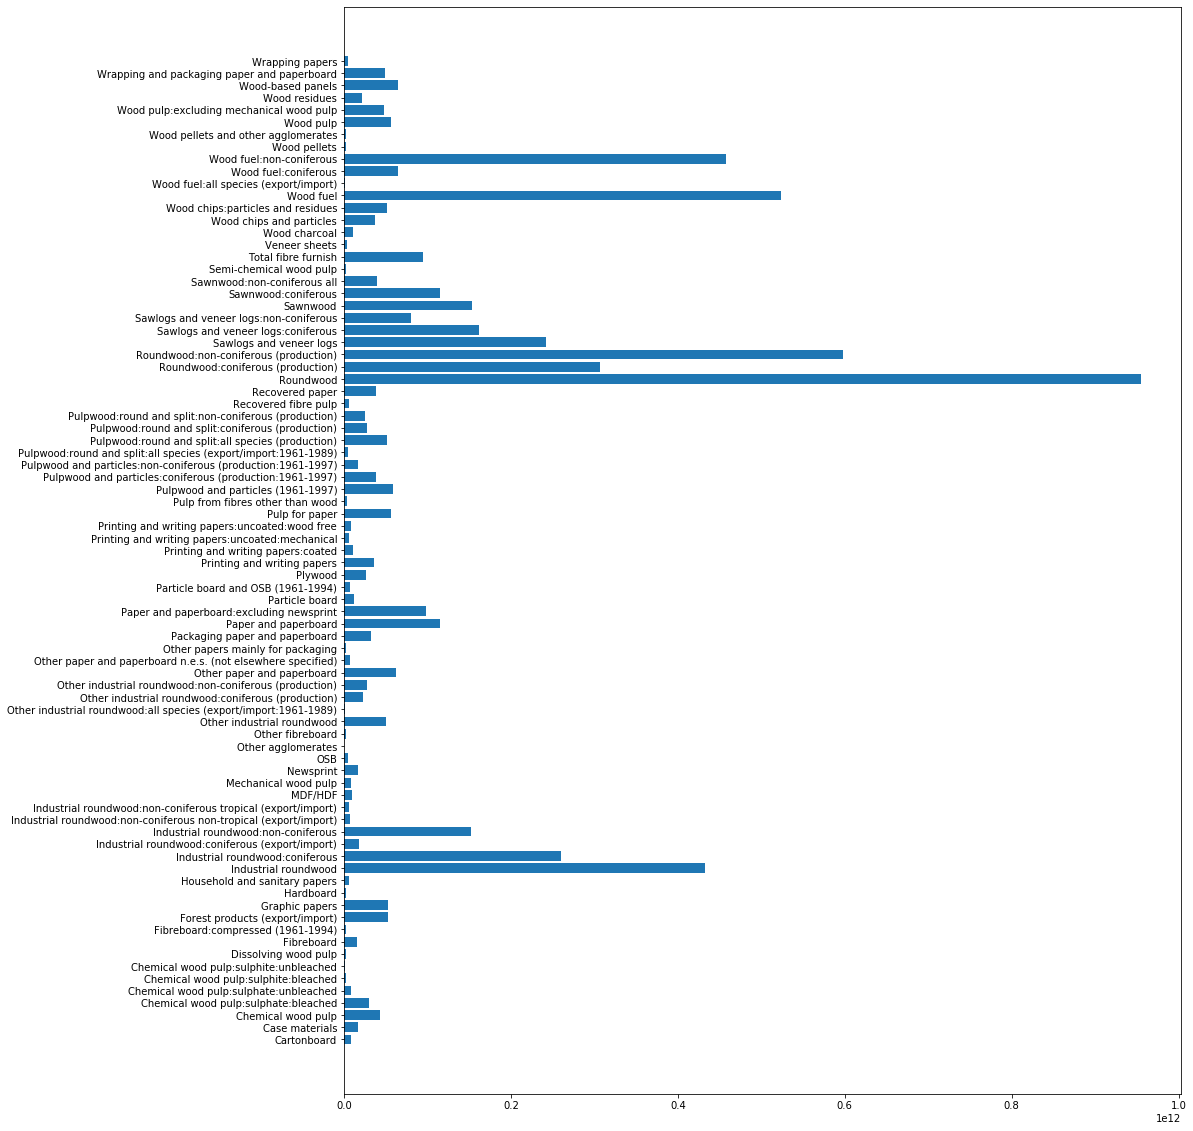

In [910]:
items_total = forest_all.groupby('Item').sum().loc[:, 'Value']
plt.figure(figsize=(15,20))
plt.barh(items_total.index, items_total.values)
plt.show()

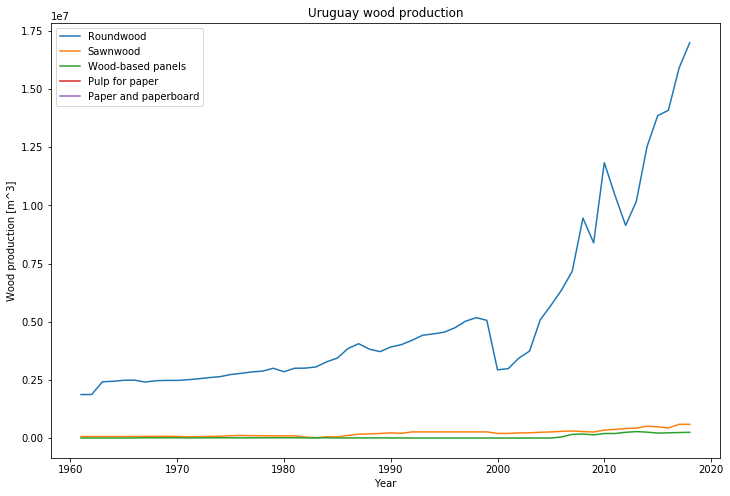

In [914]:
# NEW

# Types of wood production.
# Plot only 5 main categories
COUNTRY = 'Uruguay'

country_total_production = forest_all[forest_all.Element.str.match("Production") & 
                                      forest_all.Area.str.match(COUNTRY) & 
                                      forest_all.Unit.str.match("m3")]

significant_items = ['Roundwood',
                     'Sawnwood',
                     'Wood-based panels',
                     'Pulp for paper',
                     'Paper and paperboard']

# Plot
plt.figure(figsize=(12, 8))
for ITEM in significant_items:
    country_selected_item = country_total_production[country_total_production.Item == ITEM]
    plt.plot(country_selected_item.Year,
             country_selected_item.Value)
plt.title(COUNTRY + " wood production")
plt.legend(significant_items)
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Wood production [m^3]')
plt.show()

## Is agricultural industry influencing deforestation? 
One of the most negative influences on the deforestation might have an agricultural industry. We've decided to investigate this possible connection.

In [ ]:
#TODO

## Is breeding farm animals influencing deforestation? 
Breeding animals might be space consumig, we've searched for the origin of the land used for this purpose.


In [ ]:
#TODO